<a href="https://colab.research.google.com/github/gabipasse/LAPES_binary_trade_bot/blob/LAPES_mel/rsi_binary_trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clonando repositório iqoption e instalando pacote dotenv**

(https://iqoptionapi.github.io/iqoptionapi/)

(https://github.com/iqoptionapi/iqoptionapi)


In [ ]:
# utilizando https

In [ ]:
pip install -U git+https://github.com/iqoptionapi/iqoptionapi.git

  Cloning https://github.com/iqoptionapi/iqoptionapi.git to /tmp/pip-req-build-k9eglvch
  Running command git clone --filter=blob:none --quiet https://github.com/iqoptionapi/iqoptionapi.git /tmp/pip-req-build-k9eglvch
  Resolved https://github.com/iqoptionapi/iqoptionapi.git to commit 8a903cc094a74af1ed935a56a2d6b5a9ed3319d7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.6/515.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
  Created wheel for iqoptionapi: filename=iqoptionapi-7.1.1-py3-none-any.whl size=82016 sha256=68216eaa9d8bbfbb85a11dd6f2079bfb87a3edc53f138ceb4781b20d311d9207
  Stored in directory: /tmp/pip-ephem-wheel-cache-vsmqvyxz/w

In [ ]:
pip install python-dotenv

# **Importando blibiotecas**

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from iqoptionapi.stable_api import IQ_Option
import time
import logging
import os
from dotenv import load_dotenv

# **Definindo funções para plot com yfinance e iqoption**

(https://analyzingalpha.com/yfinance-python)

(https://www.investopedia.com/terms/r/rsi.asp)



### funcao para calculo do rsi utilizando 14 dias anteriores

In [ ]:
def calculate_rsi(prices, period=14):

    delta = prices.diff()

    gain = delta.where(delta > 0, 0)

    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()

    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

### função para preencher as lacunas dos dados retornado pelo yfinance; api não retorna registros relativos a alguns dias

In [ ]:
def preencher_lacunas(df):

    datas = pd.date_range(start=df.index.min(), end=df.index.max())


    df = df.reindex(datas)


    df = df.ffill()

    return df

### função para sinais de compra e venda de acordo com a passagem pelos limiares de venda(>= 70) ou compra(<= 30) a partir de posições anteriores de hold

In [ ]:
def generate_signals(rsi_values):
    signals = []
    in_overbought = False
    in_oversold = False

    for rsi in rsi_values:

      if rsi > 30 and rsi < 70:

        signals.append('HOLD')

        in_overbought = False
        in_oversold = False

      elif rsi >= 70 and not in_overbought:

        signals.append('SELL')

        in_overbought = True

      elif rsi <= 30 and not in_oversold:

        signals.append('BUY')

        in_oversold = True

      else:

        signals.append('HOLD')

    return signals


### função para avalição da tendencia do mercado pois o indicador rsi atua melhor em mercados de range

In [ ]:
def evaluate_market_trend(data):

    data['SMA_200'] = data['Close'].rolling(window=200).mean()

    data['RSI'] = calculate_rsi(data['Close'])

    data['Trend'] = 'Range'

    data.loc[(data['RSI'] > 30) & (data['RSI'] < 70), 'Trend'] = 'Range'

    return data

### funcao para realização da chamada de api, utilizando a funcao data_filled desenvolvida anteriormente para preencher lacunas nos registros

In [ ]:
def get_historical_data(symbol, start_date, end_date):

    data = yf.download(symbol, start=start_date, end=end_date)

    data_filled = preencher_lacunas(data)

    return data_filled


# **Plots a partir do yfinance**

(https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh)

In [ ]:
start_date = '2023-01-01'

In [ ]:
end_date = '2023-07-20'

In [ ]:
tsla_df = get_historical_data('TSLA', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
rsi_values = calculate_rsi(tsla_df['Close'])

In [ ]:
rsi_values.head(14)

2023-01-03          NaN
2023-01-04          NaN
2023-01-05          NaN
2023-01-06          NaN
2023-01-07          NaN
2023-01-08          NaN
2023-01-09          NaN
2023-01-10          NaN
2023-01-11          NaN
2023-01-12          NaN
2023-01-13          NaN
2023-01-14          NaN
2023-01-15          NaN
2023-01-16    78.438027
Freq: D, Name: Close, dtype: float64

In [ ]:
tsla_df['RSI'] = rsi_values

In [ ]:
tsla_df[tsla_df.index == '2023-05-21']

,Open,High,Low,Close,Adj Close,Volume,RSI
2023-05-21,177.169998,181.949997,176.309998,180.139999,180.139999,136024200.0,64.044871


In [ ]:
tsla_df['Signal'] = generate_signals(tsla_df['RSI'])

In [ ]:
tsla_df = evaluate_market_trend(tsla_df)

In [ ]:
tsla_df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend
2023-07-15,277.010010,285.299988,276.309998,281.380005,281.380005,119771100.0,67.420274,HOLD,NaN,Range
2023-07-16,277.010010,285.299988,276.309998,281.380005,281.380005,119771100.0,67.420274,HOLD,NaN,Range
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600.0,73.117890,SELL,NaN,Range
2023-07-18,290.149994,295.260010,286.010010,293.339996,293.339996,112434700.0,74.685873,HOLD,NaN,Range
2023-07-19,296.040009,299.290009,289.519989,291.260010,291.260010,142355400.0,71.528598,HOLD,NaN,Range


In [ ]:
tsla_df[tsla_df['RSI'] >= 70]['RSI']

2023-01-16    78.438027
2023-01-17    87.379984
2023-01-18    77.112587
2023-01-19    71.720787
2023-01-20    78.117355
                ...    
2023-07-04    71.860982
2023-07-05    72.994116
2023-07-17    73.117890
2023-07-18    74.685873
2023-07-19    71.528598
Name: RSI, Length: 66, dtype: float64

In [ ]:
tsla_df[tsla_df['Signal'] == 'BUY']['RSI']

2023-04-20    26.92402
Freq: D, Name: RSI, dtype: float64

In [ ]:
tsla_df[tsla_df['RSI'] <= 30]['RSI']

2023-04-20    26.924020
2023-04-21    29.928526
2023-04-22    29.928526
2023-04-23    29.928526
2023-04-24    28.176980
2023-04-25    26.916382
2023-04-26    22.861974
Freq: D, Name: RSI, dtype: float64

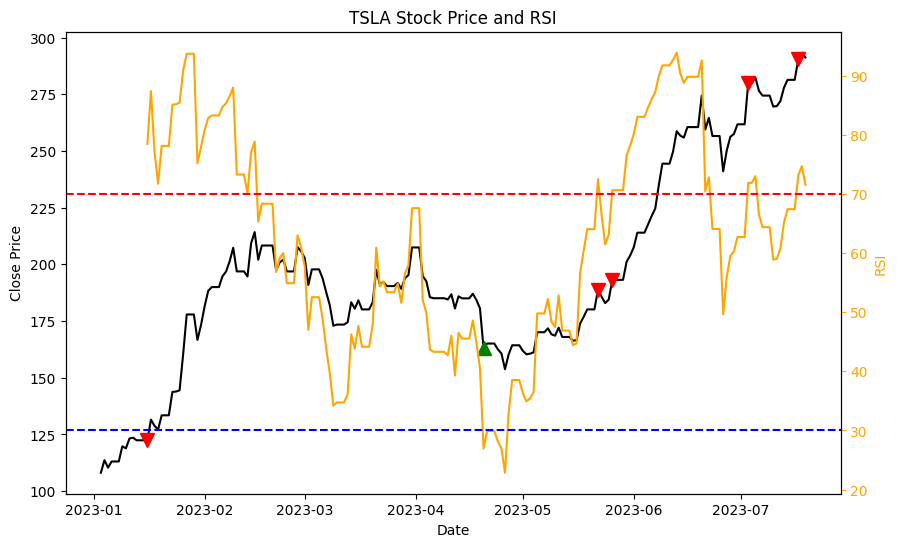

In [ ]:
# plot simples utilizando matplotlib

fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.plot(tsla_df.index, tsla_df['Close'], label='Close', color='black')

ax1.set_xlabel('Date')

ax1.set_ylabel('Close Price', color='black')

ax1.tick_params('y', colors='black')


ax2 = ax1.twinx()

ax2.plot(tsla_df.index, tsla_df['RSI'], label='RSI', color='orange')

ax2.set_ylabel('RSI', color='orange')

ax2.tick_params('y', colors='orange')


for index, row in tsla_df.iterrows():

    if row['Signal'] == 'BUY':

        ax1.plot(index, row['Close'], 'g^', markersize=10)

    elif row['Signal'] == 'SELL':

        ax1.plot(index, row['Close'], 'rv', markersize=10)


ax2.axhline(y=30, color='blue', linestyle='--', label='RSI 30')

ax2.axhline(y=70, color='red', linestyle='--', label='RSI 70')

plt.title('TSLA Stock Price and RSI')

plt.show()

In [ ]:
# modificar para candle (candlestick) FEITO

In [ ]:
len(tsla_df)

198

Implementando o candlestick cinza


In [ ]:
# velas vermelhas = fechamento menor do que o fechamento do dia anterior. velhas verdes = fechamento maior do que o fechamento do dia anterior.
# velas ocas = fechamento maior do que a abertura. velas sólidas = fechamento menor do que a abertura

In [ ]:
# plot interativo utilizando plotly. Divido em velas e rsi mas ainda sem as sinalizações

tsla_df["previousClose"] = tsla_df["Close"].shift(1)


tsla_df["color"] = np.where(
        tsla_df["Close"] == tsla_df["previousClose"],
        "gray",
        np.where(tsla_df["Close"] > tsla_df["previousClose"], "green", "red")
    )

tsla_df["fill"] = np.where(tsla_df["Close"] > tsla_df["Open"], "rgba(255, 0, 0, 0)", tsla_df["color"])


fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in tsla_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"]))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["Open"]],
            high=[row["High"]],
            low=[row["Low"]],
            close=[row["Close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=tsla_df.index, y=tsla_df['RSI'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


fig.update_layout(title="TSLA Stock Price and RSI (Last 14 days)",

                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))


fig.show()

In [ ]:
# Melhoria do plot anterior, agora com sinalizações de compra e venda

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in tsla_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"]))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["Open"]],
            high=[row["High"]],
            low=[row["Low"]],
            close=[row["Close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=tsla_df.index, y=tsla_df['RSI'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


for index, row in tsla_df.iterrows():


    if row['Signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['RSI']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
    elif row['Signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['RSI']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )



fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="TSLA Stock Price and RSI (Last 14 days)",
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  font_color="white",  # Adjust as needed

                  xaxis_rangeslider_visible=False,
                  yaxis2=dict(title="RSI", range=[0, 100]))

fig.show()

In [ ]:
tsla_df[tsla_df.index == '2023-05-21']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend,previousClose,color,fill
2023-05-21,177.169998,181.949997,176.309998,180.139999,180.139999,136024200.0,64.044871,HOLD,NaN,Range,180.139999,gray,"rgba(255, 0, 0, 0)"


In [ ]:
tsla_df[(tsla_df.index == '2023-05-21') & (tsla_df['RSI'] >= 70)]

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend,previousClose,color,fill


In [ ]:
tsla_df[tsla_df['Signal'] != 'HOLD']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,SMA_200,Trend,previousClose,color,fill
2023-01-16,116.550003,122.629997,115.599998,122.400002,122.400002,180714100.0,78.438027,SELL,NaN,Range,122.400002,gray,"rgba(255, 0, 0, 0)"
2023-04-20,166.169998,169.699997,160.559998,162.990005,162.990005,210970800.0,26.924020,BUY,NaN,Range,180.589996,red,red
2023-05-22,180.699997,189.320007,180.110001,188.869995,188.869995,132001400.0,72.498857,SELL,NaN,Range,180.139999,green,"rgba(255, 0, 0, 0)"
2023-05-26,184.619995,198.600006,184.529999,193.169998,193.169998,162061500.0,70.626125,SELL,NaN,Range,184.470001,green,"rgba(255, 0, 0, 0)"
2023-07-03,276.489990,284.250000,275.109985,279.820007,279.820007,119685900.0,71.860982,SELL,NaN,Range,261.769989,green,"rgba(255, 0, 0, 0)"
2023-07-17,286.630005,292.230011,283.570007,290.380005,290.380005,131569600.0,73.117890,SELL,NaN,Range,281.380005,green,"rgba(255, 0, 0, 0)"


**Melhorias da reunião 25 Janeiro**

In [ ]:
# rsi separado do plot principal (gráfico) > makesubplot(para plotar grafico principal em cima e rsi embaixo)  FEITO

In [ ]:
# plotly (graficos interativos) / dash (mesma coisa) > desenvolvimento web FEITO

In [ ]:
# analisar tendencia (calculo simples de ema ou sma) FALTA

In [ ]:
# utilizar ap iq (50 a 100 velas) >> get_candles (! Nao pega a do momento atual no montante !). estrutura de deck (nao array). Nao sobrescreve o candle (entao tem que passar um loop na chamada de funcao) FEITO

In [ ]:
# colocar minha senha e email num .env FEITO

# **Plot a partir da iqoption**

(https://medium.com/@maxwell.langford/its-2023-stop-leaking-secrets-in-google-colab-part-2-8215d47a76f2)



In [ ]:
# o arquivo .env já deve estar montado no ambiente de execução a partir dessa célula

In [ ]:
load_dotenv()

False

In [ ]:
iqoption_email = os.getenv("my_email")

In [ ]:
iqoption_email

In [ ]:
iqoption_password = os.getenv("my_password")

In [ ]:
iqoption_password

In [ ]:
# logando na conta iqoption atráves da api iqoption

In [ ]:
logging.basicConfig(level=logging.DEBUG,format='%(asctime)s %(message)s')
Iq=IQ_Option('mel22070219@aluno.cesupa.br', 'iqoptionsenha')

In [ ]:
# checando resposta da requisição

In [ ]:
check, reason=Iq.connect()
print(check, reason)

True None


In [ ]:
goal="EURUSD"

In [ ]:
# pegando os valores das velas (lembrando que utiliza deck)
velas = Iq.get_candles(goal,60,111,time.time())

In [ ]:
len(velas)

111

In [ ]:
type(velas)

list

In [ ]:
velas[0]

{'id': 2379004,
 'from': 1710274980,
 'at': 1710275040000000000,
 'to': 1710275040,
 'open': 1.092535,
 'close': 1.092545,
 'min': 1.092515,
 'max': 1.092555,
 'volume': 81}

In [ ]:
velas[-1]

{'id': 2379114,
 'from': 1710281580,
 'at': 1710281583000000000,
 'to': 1710281640,
 'open': 1.092705,
 'close': 1.092705,
 'min': 1.092705,
 'max': 1.09271,
 'volume': 4}

In [ ]:
EURUSD_df = pd.DataFrame(velas)

**Checando valores faltantes no dataframe originado**

In [ ]:
EURUSD_df.head()

,id,from,at,to,open,close,min,max,volume
0,2379004,1710274980,1710275040000000000,1710275040,1.092535,1.092545,1.092515,1.092555,81
1,2379005,1710275040,1710275100000000000,1710275100,1.092545,1.092545,1.092520,1.092555,87
2,2379006,1710275100,1710275160000000000,1710275160,1.092545,1.092560,1.092520,1.092560,89
3,2379007,1710275160,1710275220000000000,1710275220,1.092560,1.092540,1.092525,1.092570,112
4,2379008,1710275220,1710275280000000000,1710275280,1.092550,1.092545,1.092520,1.092555,84


In [ ]:
EURUSD_df.isna().sum()

id        0
from      0
at        0
to        0
open      0
close     0
min       0
max       0
volume    0
dtype: int64

In [ ]:
rsi_values_2 = calculate_rsi(EURUSD_df['close'])

In [ ]:
EURUSD_df['rsi'] = rsi_values_2

In [ ]:
EURUSD_df['rsi'].isna().sum()

13

In [ ]:
EURUSD_df['signal'] = generate_signals(EURUSD_df['rsi'])

In [ ]:
EURUSD_df['signal'].isna().sum()

0

In [ ]:
EURUSD_df['signal'].unique()

array(['HOLD', 'SELL'], dtype=object)

In [ ]:
EURUSD_df["previousClose"] = EURUSD_df["close"].shift(1)


EURUSD_df["color"] = np.where(
           EURUSD_df["close"] == EURUSD_df["previousClose"],
          "gray",
          np.where(EURUSD_df["close"] > EURUSD_df["previousClose"], "green", "red")
  )


EURUSD_df["fill"] = np.where(EURUSD_df["close"] > EURUSD_df["open"], "rgba(255, 0, 0, 0)", EURUSD_df["color"])

In [ ]:
EURUSD_df[["previousClose", "color", "fill"]].isna().sum()

previousClose    1
color            0
fill             0
dtype: int64

**Checando valores únicos presentes no dataframe**

In [ ]:
EURUSD_df["color"].unique()

array(['red', 'gray', 'green'], dtype=object)

In [ ]:
EURUSD_df["fill"].unique()

array(['rgba(255, 0, 0, 0)', 'gray', 'red', 'green'], dtype=object)

In [ ]:
# rgba(255, 0, 0, 0) == green

In [ ]:
from plotly.io import templates
templates.default = 'plotly_dark'

templates['plotly_dark'].layout.paper_bgcolor = 'black'
templates['plotly_dark'].layout.plot_bgcolor = 'black'

templates['plotly_dark'].layout.xaxis.gridcolor = 'rgba(0,0,0,0)'


templates['plotly_dark'].layout.yaxis.gridcolor ='rgba(0,0,0,0)'


In [ ]:
# Plot a partir do dataframe gerado com dados requisitado da api iqoption. Possui sinalização básica utilizando apenas limiares de rsi

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI"))


for index, row in EURUSD_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"]))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["open"]],
            high=[row["max"]],
            low=[row["min"]],
            close=[row["close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=EURUSD_df.index, y=EURUSD_df['rsi'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)


for index, row in EURUSD_df.iterrows():

     if row['signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
     elif row['signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )


fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="EURUSD",
                  xaxis_rangeslider_visible=False,

                  font_color="white",
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False),
                  yaxis2=dict(title="RSI", range=[0, 100],showgrid=False),
                  xaxis2=dict(range=[0, 100],showgrid=False),
    )


fig.show()

#**Melhorias da reunião 15 fevereiro**

In [ ]:
# combinar rsi com "momentum" FALTA


 candle cinza quando fechamento igual a abertura **FEITO**

In [ ]:

EURUSD_df["previousClose"] = EURUSD_df["close"].shift(1)


EURUSD_df["color"] = np.where(
           EURUSD_df["close"] == EURUSD_df["previousClose"],
          "gray",
          np.where(EURUSD_df["close"] > EURUSD_df["previousClose"], "green", "red")
  )


EURUSD_df["fill"] = np.where(EURUSD_df["close"] > EURUSD_df["open"], "rgba(255, 0, 0, 0)", EURUSD_df["color"])

In [ ]:
# iq get techinical indicator documentacao api Feito

In [ ]:
# usar pivots (suporte resistencia) fibonacci (pontos compra ou venda) principais sao os mais proximos de 50 < o cara do mercadO FALTA

In [ ]:
# fazer as entradas FALTA

In [ ]:
# testar stoachstic rsi FALTA

fazer cor so no plot, nao no dataframe **FEITO**

 # api iq option techinical analysis




In [ ]:
indicators = Iq.get_technical_indicators(goal)

In [ ]:
indicators_df = pd.DataFrame(indicators)
indicators_df

,action,candle_size,group,name,value
0,hold,60,OSCILLATORS,Relative Strength Index (14),51.704281
1,hold,60,OSCILLATORS,"Stochastic %K (14, 3, 3)",48.717949
2,hold,60,OSCILLATORS,Commodity Channel Index (20),14.629049
3,hold,60,OSCILLATORS,Average Directional Index (14),19.955721
4,hold,60,OSCILLATORS,Awesome Oscillator,0.000003
...,...,...,...,...,...
451,hold,2592000,PIVOTS,Woodie r1,1.114940
452,hold,2592000,PIVOTS,Woodie r2,1.136688
453,hold,2592000,PIVOTS,DeMark s1,1.058865
454,hold,2592000,PIVOTS,DeMark p,1.086415


In [ ]:
rsi_df = indicators_df[indicators_df['name'] == 'Relative Strength Index (14)'].reset_index(drop=True)
rsi_df.sort_values('value')

,action,candle_size,group,name,value
3,hold,3600,OSCILLATORS,Relative Strength Index (14),50.398495
7,hold,2592000,OSCILLATORS,Relative Strength Index (14),51.226837
0,hold,60,OSCILLATORS,Relative Strength Index (14),51.704281
4,hold,14400,OSCILLATORS,Relative Strength Index (14),54.709656
6,hold,604800,OSCILLATORS,Relative Strength Index (14),55.572941
2,hold,900,OSCILLATORS,Relative Strength Index (14),60.157959
1,hold,300,OSCILLATORS,Relative Strength Index (14),62.168373
5,hold,86400,OSCILLATORS,Relative Strength Index (14),62.972969


#plots ema

In [ ]:
'''When 5-day EMA is greater than 10-day EMA, and both 5-day and 10-day EMA are greater than 20-day EMA,
which means 5-day and 10-day EMA cross above 20-day EMA, generate buy signal.
When 10-day EMA is less than 5-day EMA, and both 5-day and 10-day EMA are less
than 20-day EMA, which means 5-day and 10-day EMA cross below 20-day EMA, generate sell signal.'''

'When 5-day EMA is greater than 10-day EMA, and both 5-day and 10-day EMA are greater than 20-day EMA,\nwhich means 5-day and 10-day EMA cross above 20-day EMA, generate buy signal.\nWhen 10-day EMA is less than 5-day EMA, and both 5-day and 10-day EMA are less\nthan 20-day EMA, which means 5-day and 10-day EMA cross below 20-day EMA, generate sell signal.'

##ema 5

In [ ]:
ema_5_df = indicators_df[indicators_df['name'] == 'Exponential Moving Average (5)'].reset_index(drop=True)

In [ ]:
ema_5_df.head()

,action,candle_size,group,name,value
0,buy,60,MOVING AVERAGES,Exponential Moving Average (5),1.092721
1,buy,300,MOVING AVERAGES,Exponential Moving Average (5),1.092719
2,buy,900,MOVING AVERAGES,Exponential Moving Average (5),1.092689
3,buy,3600,MOVING AVERAGES,Exponential Moving Average (5),1.092579
4,buy,14400,MOVING AVERAGES,Exponential Moving Average (5),1.092557


In [ ]:
ema_5_df.shape

(8, 5)

In [ ]:
#Plot com os pontos marcados definindo os momentos de entrada. Os de hold como cinza, buy verde e sell vermelho (EMA 5)

fig = go.Figure()


fig.add_trace(
    go.Scatter(x=ema_5_df.index, y=ema_5_df['value'], mode='lines', name='RSI', marker=dict(color='orange'))
)


for index, row in ema_5_df.iterrows():

    if row['action'] == 'buy':

      color = 'green'

    elif row['action'] == 'sell':

      color = 'red'

    else:

      color = 'grey'


    fig.add_trace(
        go.Scatter(
            x=[index],
            y=[row['value']],
            mode="markers",
            marker=dict(color=color),
            showlegend=False
        )
    )


fig.update_layout(
    title="Valores (EMA 5) em relação ao Candle Size",
    xaxis_title="Candle Size",
    yaxis_title="Valor (EMA 5)"
)


fig.show()

##ema 10


In [ ]:
ema_10_df = indicators_df[indicators_df['name'] == 'Exponential Moving Average (10)'].reset_index(drop=True)
ema_10_df

,action,candle_size,group,name,value
0,buy,60,MOVING AVERAGES,Exponential Moving Average (10),1.092722
1,buy,300,MOVING AVERAGES,Exponential Moving Average (10),1.092706
2,buy,900,MOVING AVERAGES,Exponential Moving Average (10),1.092605
3,buy,3600,MOVING AVERAGES,Exponential Moving Average (10),1.092488
4,buy,14400,MOVING AVERAGES,Exponential Moving Average (10),1.092702
5,buy,86400,MOVING AVERAGES,Exponential Moving Average (10),1.089947
6,buy,604800,MOVING AVERAGES,Exponential Moving Average (10),1.086836
7,buy,2592000,MOVING AVERAGES,Exponential Moving Average (10),1.083779


In [ ]:
#Plot com os pontos marcados definindo os momentos de entrada. Os de hold como cinza, buy verde e sell vermelho (EMA 10)

fig = go.Figure()


fig.add_trace(
    go.Scatter(x=ema_10_df.index, y=ema_10_df['value'], mode='lines', name='RSI', marker=dict(color='orange'))
)


for index, row in ema_10_df.iterrows():

    if row['action'] == 'buy':

      color = 'green'

    elif row['action'] == 'sell':

      color = 'red'

    else:

      color = 'grey'


    fig.add_trace(
        go.Scatter(
            x=[index],
            y=[row['value']],
            mode="markers",
            marker=dict(color=color),
            showlegend=False
        )
    )


fig.update_layout(
    title="Valores (EMA 10) em relação ao Candle Size",
    xaxis_title="Candle Size",
    yaxis_title="Valor (EMA 10)"
)


fig.show()

##ema 10 e ema 5

In [ ]:
# Plot combinando os valores de RSI, EMA (tanto ema 10 quanto 5)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("EMA (5 e 10 períodos)", "RSI"))

fig.add_trace(go.Scatter(x=ema_10_df.index, y=ema_10_df['value'], mode='lines', name='EMA 10', line=dict(color='blue')), row=1, col=1)

fig.add_trace(go.Scatter(x=ema_5_df.index, y=ema_5_df['value'], mode='lines', name='EMA 5', line=dict(color='green')), row=1, col=1)

fig.update_xaxes(title_text="Candle Size", row=1, col=1)
fig.update_yaxes(title_text="Valor", row=1, col=1)

fig.add_trace(go.Scatter(x=rsi_df.index, y=rsi_df['value'], mode='lines', name='RSI', line=dict(color='orange')), row=2, col=1)

fig.update_xaxes(title_text="Candle Size", row=2, col=1)
fig.update_yaxes(title_text="Valor", row=2, col=1)

fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")

fig.update_layout(title="Valores de EMA (5 e 10 períodos) e RSI em relação ao Candle Size")

fig.show()



##ema 5, 10 e 20

In [ ]:
ema_20_df = indicators_df[indicators_df['name'] == 'Exponential Moving Average (20)'].reset_index(drop=True)
ema_20_df

,action,candle_size,group,name,value
0,buy,60,MOVING AVERAGES,Exponential Moving Average (20),1.092720
1,buy,300,MOVING AVERAGES,Exponential Moving Average (20),1.092664
2,buy,900,MOVING AVERAGES,Exponential Moving Average (20),1.092434
3,buy,3600,MOVING AVERAGES,Exponential Moving Average (20),1.092595
4,buy,14400,MOVING AVERAGES,Exponential Moving Average (20),1.092346
5,buy,86400,MOVING AVERAGES,Exponential Moving Average (20),1.087105
6,buy,604800,MOVING AVERAGES,Exponential Moving Average (20),1.085172
7,buy,2592000,MOVING AVERAGES,Exponential Moving Average (20),1.083468


In [ ]:


fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("EMA (5 e 10 períodos)", "RSI"))

fig.add_trace(go.Scatter(x=ema_10_df.index, y=ema_10_df['value'], mode='lines', name='EMA 10', line=dict(color='blue')), row=1, col=1)

fig.add_trace(go.Scatter(x=ema_5_df.index, y=ema_5_df['value'], mode='lines', name='EMA 5', line=dict(color='green')), row=1, col=1)


fig.add_trace(go.Scatter(x=ema_20_df.index, y=ema_20_df['value'], mode='lines', name='EMA 20', line=dict(color='red')), row=1, col=1)

fig.update_xaxes(title_text="Candle Size", row=1, col=1)
fig.update_yaxes(title_text="Valor", row=1, col=1)

fig.add_trace(go.Scatter(x=rsi_df.index, y=rsi_df['value'], mode='lines', name='RSI', line=dict(color='orange')), row=2, col=1)

fig.update_xaxes(title_text="Candle Size", row=2, col=1)
fig.update_yaxes(title_text="Valor", row=2, col=1)

fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")

fig.update_layout(title="Valores de EMA (5 e 10 e 20 períodos) e RSI em relação ao Candle Size")

fig.show()

#FIBONACCI


https://www.cmcmarkets.com/en/trading-guides/how-to-trade-with-fibonacci
https://www.infomoney.com.br/mercados/ibovespa-rompe-a-media-movel-de-200-periodos-por-que-preciso-saber-disso/#:~:text=Uma%20estrat%C3%A9gia%20comum%20entre%20os,linha%20de%20cima%20para%20baixo.


https://www.cmcmarkets.com/en/trading-guides/how-to-trade-with-fibonacci

In financial markets, the Fibonacci golden ratio has the same mathematical base as the natural phenomena mentioned above. When traders use the golden ratio in their technical analysis, the ratio is usually translated into three percentages: 38.2% (often rounded to 38%), 50% and 61.8% (usually rounded to 62%). Having said that, traders can use more multiples when necessary, such as: 23.6%, 161.8%, 423%, 684.4% and so on.

The 38.2% ratio is found by dividing one number in the series by the number two places to the right. For example, 21 divided by 55 equals 0.382. The 23.6% ratio divides one number in the series by the number three places to the right. For example, 8 divided by 34 equals 0.235.

In [ ]:
EURUSD_df["fibonacci"] = (
    EURUSD_df["close"].shift(-2) / EURUSD_df["close"].shift(1)
)
# 38.2% ratio
EURUSD_df["fibonacci_38.2"] = EURUSD_df["fibonacci"].apply(lambda x: x * 0.382)

In [ ]:
# Plot a partir do dataframe gerado com dados requisitado da api iqoption. Possui sinalização básica utilizando apenas limiares de rsi

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Candlestick", "RSI","Fibonacci"))


for index, row in EURUSD_df.iterrows():
    color = dict(fillcolor=row["fill"], line=dict(color=row["color"]))
    fig.add_trace(
        go.Candlestick(
            x=[index],
            open=[row["open"]],
            high=[row["max"]],
            low=[row["min"]],
            close=[row["close"]],
            increasing=color,
            decreasing=color,
            showlegend=False,
        ),
        row=1, col=1
    )


fig.add_trace(
    go.Scatter(x=EURUSD_df.index, y=EURUSD_df['rsi'], mode='lines', name='RSI', marker=dict(color='orange')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=EURUSD_df.index, y=EURUSD_df['fibonacci_38.2'], mode='lines', name='Fibonacci 38.2%', marker=dict(color='purple')),
    row=3, col=1
)

for index, row in EURUSD_df.iterrows():

     if row['signal'] == 'SELL':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='red'), showlegend=False),
            row=2, col=1
        )
     elif row['signal'] == 'BUY':
        fig.add_trace(
            go.Scatter(x=[index], y=[row['rsi']], mode='markers', marker=dict(color='green'), showlegend=False),
            row=2, col=1
        )


fig.add_hline(y=30, line_dash="dash", line_color="blue", row=2, col=1, name="RSI 30")
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1, name="RSI 70")


fig.update_layout(title="EURUSD",
                  xaxis_rangeslider_visible=False,

                  font_color="white",
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False),
                  yaxis2=dict(title="RSI", range=[0, 100],showgrid=False),
                  xaxis2=dict(range=[0, 100],showgrid=False),
    )


fig.show()

#SMA

In [ ]:
"""
A simple moving average (SMA) calculates the average of a selected range of prices,
usually closing prices, by the number of periods in that range.
A simple moving average (SMA) is an arithmetic moving average calculated by adding
recent prices and then dividing that figure by the number of time periods in the calculation average
"""
"https://www.investopedia.com/terms/s/sma.asp#:~:text=A%20simple%20moving%20average%20(SMA)%20is%20an%20arithmetic%20moving%20average,periods%20in%20the%20calculation%20average."

In [ ]:
#smv 50

In [ ]:
EURUSD_df['sma50'] = EURUSD_df['close'].rolling(50,min_periods=1).mean()
EURUSD_df
#q porra?


,id,from,at,to,open,close,min,max,volume,rsi,signal,previousClose,color,fill,fibonacci,fibonacci_38.2,sma50
0,2379004,1710274980,1710275040000000000,1710275040,1.092535,1.092545,1.092515,1.092555,81,NaN,HOLD,NaN,red,"rgba(255, 0, 0, 0)",NaN,NaN,1.092545
1,2379005,1710275040,1710275100000000000,1710275100,1.092545,1.092545,1.092520,1.092555,87,NaN,HOLD,1.092545,gray,gray,0.999995,0.381998,1.092545
2,2379006,1710275100,1710275160000000000,1710275160,1.092545,1.092560,1.092520,1.092560,89,NaN,HOLD,1.092545,green,"rgba(255, 0, 0, 0)",1.000000,0.382000,1.092550
3,2379007,1710275160,1710275220000000000,1710275220,1.092560,1.092540,1.092525,1.092570,112,NaN,HOLD,1.092560,red,red,1.000032,0.382012,1.092548
4,2379008,1710275220,1710275280000000000,1710275280,1.092550,1.092545,1.092520,1.092555,84,NaN,HOLD,1.092540,green,green,1.000014,0.382005,1.092547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2379110,1710281340,1710281400000000000,1710281400,1.092705,1.092720,1.092700,1.092725,67,50.771229,HOLD,1.092705,green,"rgba(255, 0, 0, 0)",1.000018,0.382007,1.092697
107,2379111,1710281400,1710281460000000000,1710281460,1.092720,1.092705,1.092700,1.092735,104,48.216558,HOLD,1.092720,red,red,0.999991,0.381997,1.092698
108,2379112,1710281460,1710281520000000000,1710281520,1.092715,1.092725,1.092700,1.092745,83,51.705835,HOLD,1.092705,green,"rgba(255, 0, 0, 0)",1.000000,0.382000,1.092700
109,2379113,1710281520,1710281580000000000,1710281580,1.092725,1.092710,1.092700,1.092735,83,49.037043,HOLD,1.092725,red,red,NaN,NaN,1.092702


<Axes: >

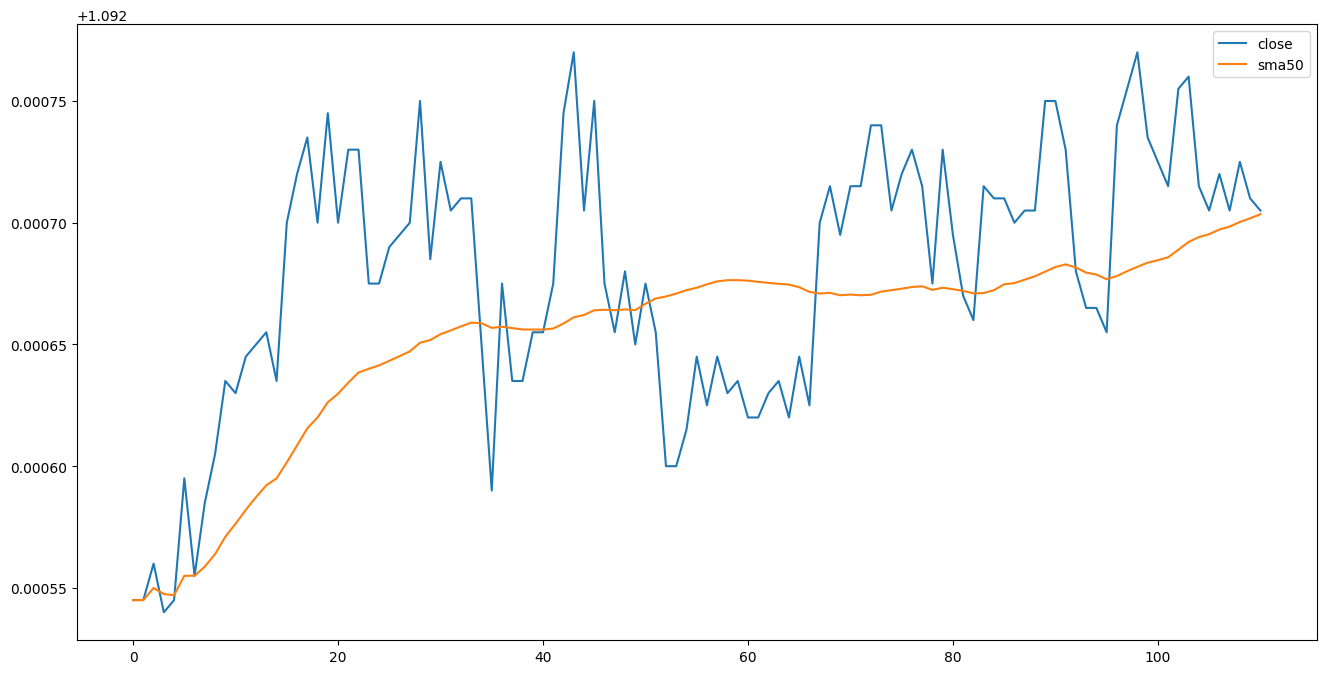

In [ ]:
EURUSD_df[['close', 'sma50']].plot(label='sma50',
                                  figsize=(16, 8))

In [ ]:
#nao da pra pegar 200 pq n tem 200 entradas ainda!!!

#get real time candle


#bollinger

In [137]:
"""
É um indicador, essencialmente, de volatilidade, ou seja, que mede a variação de preço de um ativo
 durante um determinado tempo, indicando se este está com uma alta ou uma baixa volatilidade.
 Ele faz parte da família dos indicadores envelopes (que buscam identificar as bordas superior e inferior de um trading).

Além de indicar a volatilidade do ativo, se usarmos as Bandas com uma leitura
 mais apurada e em conjunto com outros indicadores que auxiliam a análise,
 é possível identificar se ele entrou em uma tendência de alta ou de baixa.
 Também indicará se haverá uma interrupção nessa movimentação, com possíveis correções.
 https://www.infomoney.com.br/guias/bandas-bollinger/
"""

'\nÉ um indicador, essencialmente, de volatilidade, ou seja, que mede a variação de preço de um ativo\n durante um determinado tempo, indicando se este está com uma alta ou uma baixa volatilidade. \n Ele faz parte da família dos indicadores envelopes (que buscam identificar as bordas superior e inferior de um trading).\n\nAlém de indicar a volatilidade do ativo, se usarmos as Bandas com uma leitura\n mais apurada e em conjunto com outros indicadores que auxiliam a análise, \n é possível identificar se ele entrou em uma tendência de alta ou de baixa. \n Também indicará se haverá uma interrupção nessa movimentação, com possíveis correções.\n \n'

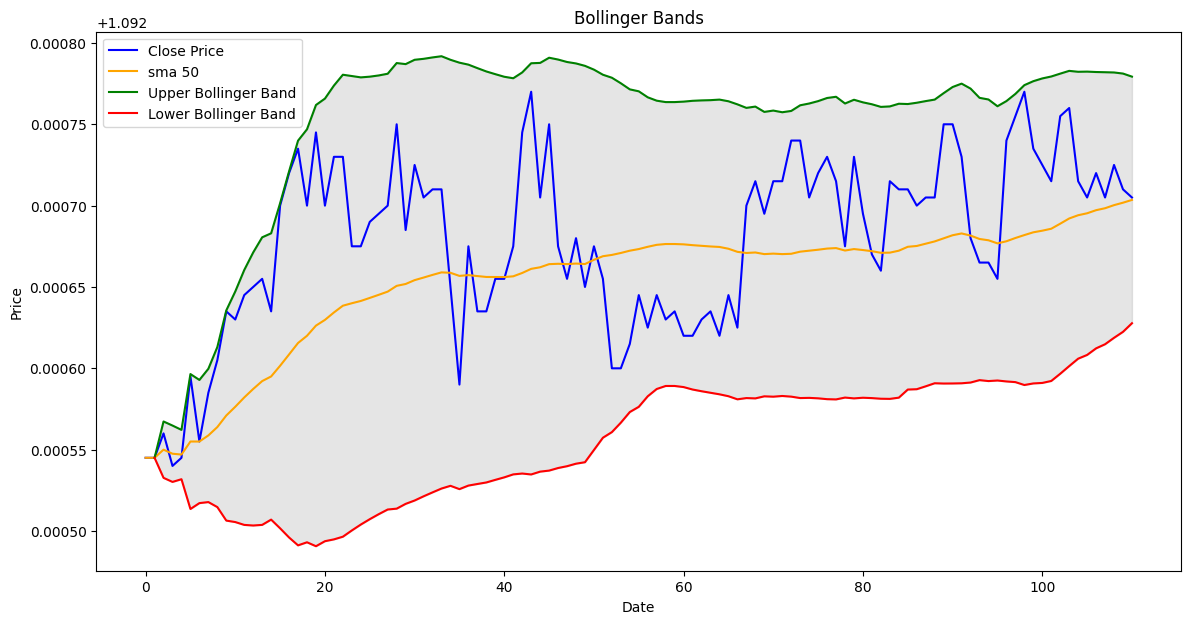

In [ ]:
std =EURUSD_df['close'].rolling(window=50,min_periods=1).std()


upper_band = EURUSD_df['sma50']+ 2 * std
lower_band = EURUSD_df['sma50'] - 2 * std

plt.figure(figsize=(14, 7))
plt.plot(EURUSD_df.index, EURUSD_df['close'], label='Close Price', color='blue')
plt.plot(EURUSD_df['sma50'], label='sma 50', color='orange')
plt.plot(upper_band.index, upper_band, label='De cima', color='green')
plt.plot(lower_band.index, lower_band, label='De baixo', color='red')
plt.fill_between(lower_band.index, lower_band, upper_band, color='gray', alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()